In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,20)
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout,BatchNormalization

In [2]:
img_size=150
batch_size=25

traingen=ImageDataGenerator(rescale=1/255.,rotation_range=50,brightness_range=[0.2,1.2],width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True)


testgen=ImageDataGenerator(rescale=1/255.)

valgen=ImageDataGenerator(rescale=1/255.)

In [3]:
traindata=traingen.flow_from_directory('C:\\Users\\LENOVO G3\\Downloads\\Pneumonia\\chest_xray\\train',target_size=(img_size,img_size),batch_size=batch_size, 
                                       shuffle=True,class_mode='binary',color_mode='grayscale')

testdata=testgen.flow_from_directory('C:\\Users\\LENOVO G3\\Downloads\\Pneumonia\\chest_xray\\test',shuffle=False,batch_size=batch_size, target_size=(img_size,img_size),
                                     class_mode='binary',color_mode='grayscale')

valdata=valgen.flow_from_directory('C:\\Users\\LENOVO G3\\Downloads\\Pneumonia\\chest_xray\\val',shuffle=False,batch_size=batch_size,
                                   target_size=(img_size,img_size), class_mode='binary',color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


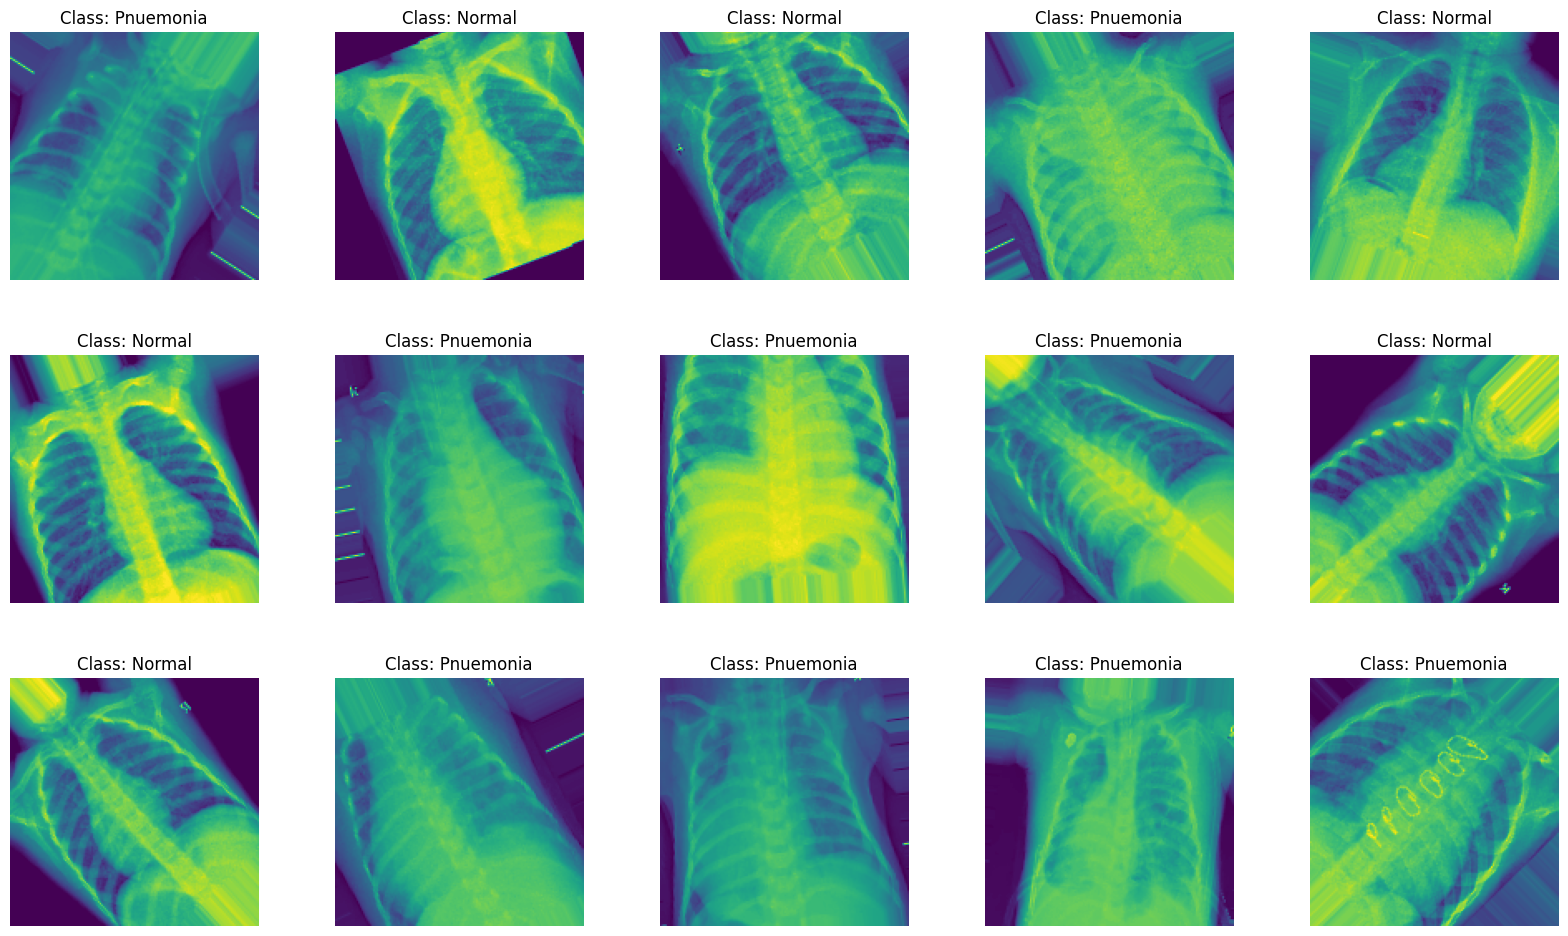

In [4]:
labels=['Normal','Pnuemonia']
samples=traindata.__next__()

images=samples[0]
target=samples[1]

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [5]:
df=pd.DataFrame(traindata.classes)
df.value_counts()

1    3875
0    1341
dtype: int64

In [6]:
df=pd.DataFrame(valdata.classes)
df.value_counts()

0    8
1    8
dtype: int64

In [7]:
df=pd.DataFrame(testdata.classes)
df.value_counts()

1    390
0    234
dtype: int64

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

model = Sequential([
    Conv2D(32, (2, 2), input_shape=(img_size, img_size, 1), activation='relu', padding='same', strides=1),
    MaxPooling2D(),
    Conv2D(64, (2, 2), strides=2, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(128, (2, 2), strides=1, activation='relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])



In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 128)        0

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath= "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)


In [12]:
history=model.fit(traindata,validation_data=valdata,epochs=50, batch_size=32, callbacks=[checkpoint])

Epoch 1/50
209/209 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.7630
Epoch 1: val_loss improved from inf to 1.21490, saving model to model_cnn.h5
209/209 [==============================] - 69s 323ms/step - loss: 0.4833 - accuracy: 0.7630 - val_loss: 1.2149 - val_accuracy: 0.5625
Epoch 2/50
209/209 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8600
Epoch 2: val_loss improved from 1.21490 to 0.57799, saving model to model_cnn.h5
209/209 [==============================] - 57s 270ms/step - loss: 0.3114 - accuracy: 0.8600 - val_loss: 0.5780 - val_accuracy: 0.8125
Epoch 3/50
209/209 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8884
Epoch 3: val_loss did not improve from 0.57799
209/209 [==============================] - 56s 270ms/step - loss: 0.2647 - accuracy: 0.8884 - val_loss: 0.6780 - val_accuracy: 0.9375
Epoch 4/50
209/209 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.8976
Epoch 4: 

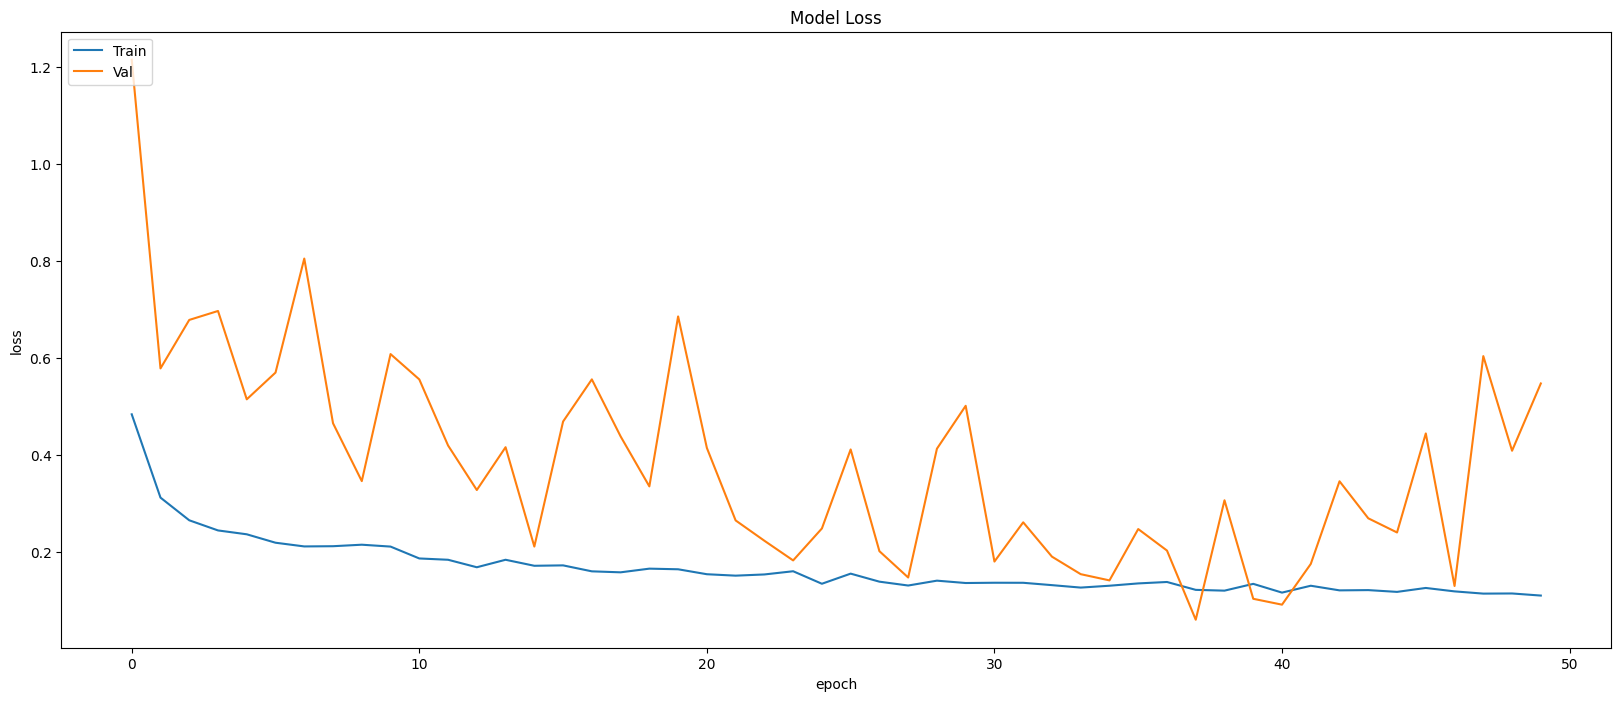

In [13]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

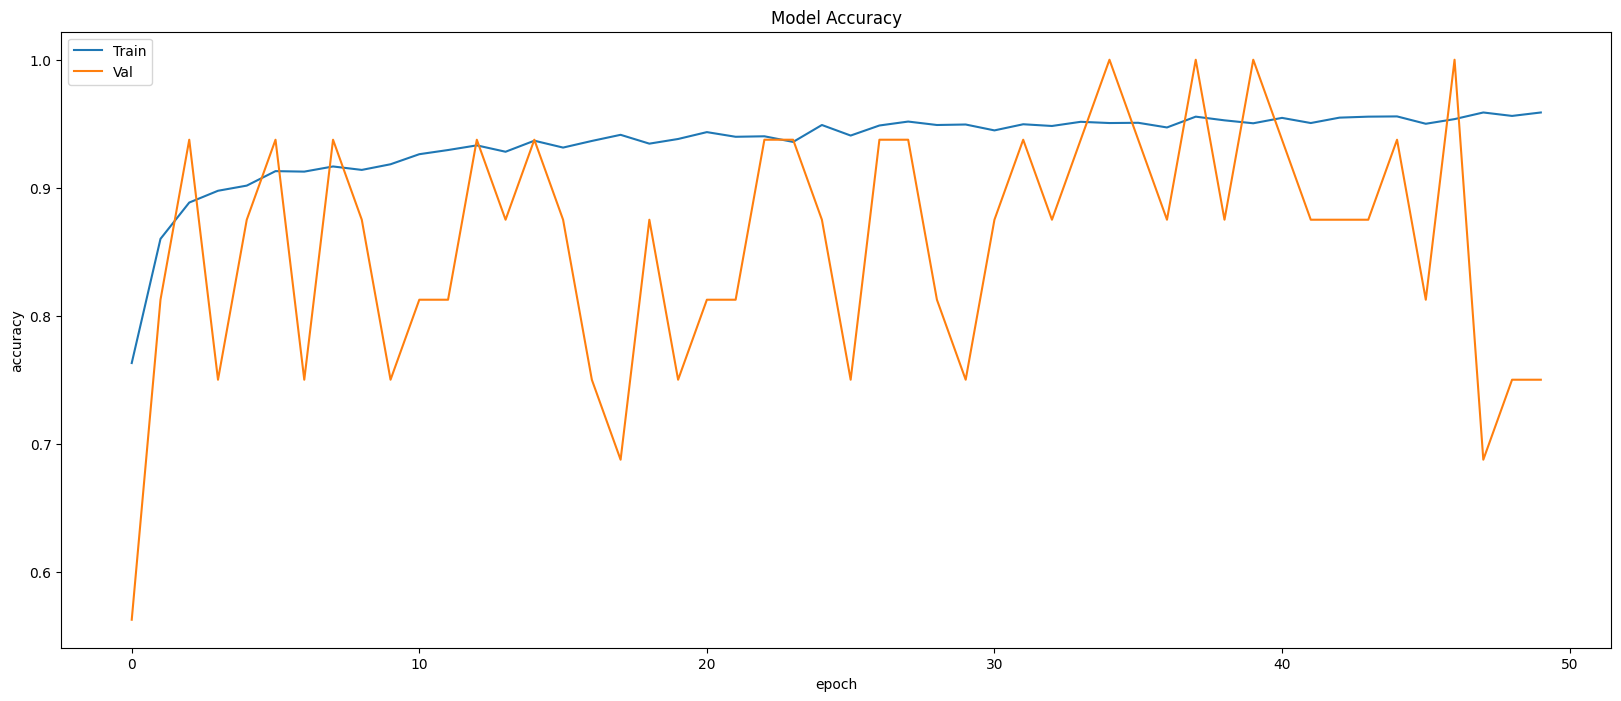

In [14]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [15]:
y_test = valdata.classes
y_pred = model.predict(valdata)
y_pred_probs = y_pred.copy()
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0  

1/1 [==============================] - 0s 239ms/step


In [18]:
y_test = testdata.classes
y_pred = model.predict(testdata)
y_pred_probs = y_pred.copy()

25/25 [==============================] - 4s 159ms/step
